In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from IPython.display import display
data = np.loadtxt('train.csv', delimiter=',', skiprows=1)
    

with open('train.csv', 'r') as f:
    data=f.read()

In [2]:
data.shape

(42000, 785)

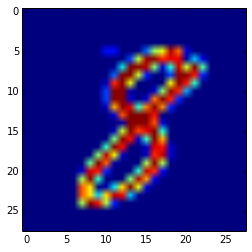

In [3]:
plt.imshow(data[20,1:].reshape(-1,28))


In [4]:
#OTS Solution
def shuffle_data(dataset):
    permutation = np.random.permutation(dataset.shape[0])
    return dataset[permutation,:]
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [5]:
size=data.shape[0]
data=shuffle_data(data)
train=data[:int(size*0.6),:]
valid=data[int(size*0.6):int(size*0.8),:]
test=data[int(size*0.8):,:]

# LogisticRegression
#lr_md=LogisticRegression()
#lr_md.fit(train[:,1:],train[:,0])
#lr_md.score(test[:,1:],test[:,1:])
image_size=28
num_labels = 10

In [36]:
def reformat(dataset, labels):
  dataset = (dataset/255).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

In [37]:
test_dataset, test_labels=reformat(test[:,1:],test[:,0])
train_dataset, train_labels=reformat(train[:,1:],train[:,0])
valid_dataset, valid_labels=reformat(valid[:,1:],valid[:,0])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (25200, 784), (25200, 10))
('Validation set', (8400, 784), (8400, 10))
('Test set', (8400, 784), (8400, 10))


In [56]:
# check class balance
train_labels.sum(axis=0)

array([ 2471.,  2864.,  2487.,  2630.,  2508.,  2287.,  2399.,  2656.,
        2403.,  2495.], dtype=float32)

In [60]:
def hid_drop_model(data, weight, bias):
    relu_layer=tf.nn.relu(tf.matmul(data, weight) + bias)
    return tf.nn.dropout(relu_layer, 0.5)

def model(data, train=False): 
    #if train:
    #    relu_layer = hid_drop_model(data, weights_1,biases_1)
    #    relu_layer = hid_drop_model(relu_layer, weights_2,biases_2)
    #else: 
    relu_layer=tf.nn.relu(tf.matmul(data, weights_1) + biases_1)
    relu_layer=tf.nn.relu(tf.matmul(relu_layer, weights_2) + biases_2)
    return tf.matmul(relu_layer, weights_3) + biases_3

hid_layer1= 1024
hid_layer2= 2048
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hid_layer1]))
    biases_1 = tf.Variable(tf.zeros([hid_layer1]))
    
    weights_2 = tf.Variable( tf.truncated_normal([hid_layer1, hid_layer2]))
    biases_2 = tf.Variable(tf.zeros([hid_layer2]))
    
    weights_3 = tf.Variable(tf.truncated_normal([hid_layer2, num_labels]))
    biases_3 = tf.Variable(tf.zeros([num_labels]))

    
    
    # Training computation.
    logits = model(tf_train_dataset, train=True)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    regularizers = (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(biases_1) +
                  tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(biases_2) +
                  tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(biases_3))
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers


    #### Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    starter_learning_rate = 0.0001
    
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               1000, 0.9, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction =  tf.nn.softmax(model(tf_test_dataset))




In [61]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 8553.241211
Minibatch accuracy: 4.7%
Validation accuracy: 9.7%
Minibatch loss at step 1000: 1012.164734
Minibatch accuracy: 86.7%
Validation accuracy: 82.6%
Minibatch loss at step 2000: 780.320312
Minibatch accuracy: 84.4%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 798.351685
Minibatch accuracy: 87.5%
Validation accuracy: 87.7%
Minibatch loss at step 4000: 677.580811
Minibatch accuracy: 93.0%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 743.518250
Minibatch accuracy: 86.7%
Validation accuracy: 88.8%
Minibatch loss at step 6000: 582.280701
Minibatch accuracy: 96.1%
Validation accuracy: 89.3%
Minibatch loss at step 7000: 644.980164
Minibatch accuracy: 93.0%
Validation accuracy: 89.5%
Minibatch loss at step 8000: 706.562134
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%
Minibatch loss at step 9000: 669.525574
Minibatch accuracy: 94.5%
Validation accuracy: 89.9%
Minibatch loss at step 10000: 587.762207
Minibatch accuracy: 

In [64]:
with open("/home/zhge/embeddings.bin.txt", "rb") as f:
    byte = f.read(1)
    while byte != "":
        print byte[:100]
        # Do stuff with byte.
        byte = f.read(1)

''

In [49]:

with open('/home/zhge/embeddings.bin.txt', 'rb') as f:
    data = f.read()
    

In [67]:
word_embedding={i.split('\t')[0]:np.array(i.split('\t')[1:-1]).astype(np.float32) for i in data.split('\n')}

In [60]:
len(key_value)

382199

In [92]:
words=word_embedding.keys()

In [84]:
np.matmul(word_embedding['swift'],word_embedding['taylor'])

0.20049503

In [91]:
np.matmul(word_embedding['peter_pan'],word_embedding['peter'])

KeyError: 'peter_pan'

In [108]:
word_embedding['harry_potter']

array([  1.50098994e-01,  -8.49530026e-02,  -1.02040004e-02,
         2.02660002e-02,  -2.19069004e-01,   1.73828006e-01,
        -1.00640997e-01,  -3.26570012e-02,  -3.47050019e-02,
         5.73199987e-02,  -4.47719991e-02,   8.45210031e-02,
        -1.08540997e-01,   2.07269993e-02,   2.37996995e-01,
         1.84567004e-01,   1.13187000e-01,  -5.41950017e-02,
        -8.03119987e-02,  -7.05329999e-02,  -1.92732006e-01,
         4.76999991e-02,  -9.09309983e-02,   4.50050011e-02,
         4.48479988e-02,   2.06099991e-02,   2.72199996e-02,
        -1.21308997e-01,  -1.08709998e-01,  -5.08509986e-02,
        -7.58469999e-02,  -2.81504989e-01,  -6.32110015e-02,
        -7.85299987e-02,  -1.19999997e-04,   1.55208007e-01,
        -3.88949998e-02,   2.33549997e-02,  -4.22499981e-03,
        -3.16389985e-02,   1.19796000e-01,   3.46710011e-02,
         6.16799993e-03,   2.96399998e-03,  -1.44114003e-01,
         4.41749990e-02,   2.48809997e-02,   1.36185005e-01,
        -6.80830032e-02,

In [107]:
words[:100]

['',
 '</s>',
 'aaaa',
 'aaaa_balls',
 'aaaa_dozen',
 'aaaa_titleist',
 'aaaa_vein',
 'aaaaa',
 'aaaaa_balls',
 'aaaaa_dozen',
 'aaaaa_recycled',
 'aaaaa_titleist',
 'aaaaaa',
 'aaaaaaa',
 'aaab',
 'aaaboxman',
 'aaabu',
 'aaac',
 'aaah',
 'aaahh_real',
 'aaajapanese',
 'aaar',
 'aaas',
 'aaas_science',
 'aaba',
 'aabb',
 'aaberg',
 'aaca',
 'aaca_arrowhead',
 'aaca_artifact',
 'aaca_gslas',
 'aacc',
 'aachen',
 'aacle',
 'aacn',
 'aacn_essentials',
 'aacp',
 'aacr',
 'aacs',
 'aacute',
 'aada',
 'aaden',
 'aaden_ballet',
 'aadm',
 'aaen',
 'aaeon',
 'aaep',
 'aafa',
 'aafa_find',
 'aafa_folk',
 'aafa_paint',
 'aafa_primitive',
 'aafc',
 'aafes',
 'aafes_pogs',
 'aagaard',
 'aagaard_jacob',
 'aage',
 'aagpbl',
 'aagpbl_fritsch',
 'aagte',
 'aahd',
 'aahs',
 'aahs_journal',
 'aahy',
 'aaker',
 'aakg',
 'aaland_mikkel',
 'aalborg',
 'aaliyah',
 'aalsmeer',
 'aalst',
 'aalto',
 'aalto_alvar',
 'aama',
 'aamazing',
 'aamc',
 'aamc_flight',
 'aamco',
 'aamer',
 'aames',
 'aames_avery',
 'aa

In [110]:
'welcomed' in words

True

In [111]:
'welcom' in words

True